# DNN Multi-Feature Credit Card Fraud Detection

# Overview
The purpose of this project is to use fully connected deep neural network (DNN) to detect the fraudulent credit card transactions in the multi-feature dataset. This is a classification problem, and the results by DNN are expected to show a multi-dimensional "decision boundary" that are hard to be defined by conventional classification techniques, e.g., SVM.

What's learned?
* Imbalanced classification
 * With imbalanced/small number of anomalies, the anomaly "duplication" during training and using dropout layers does not lead to overfitting.
* Sensitivity analysis using histogram, confusion matrix and ROC


# Data
The dataset is based on kaggle's [credit card fraud detection](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv). According to the website, the dataset contains transactions occurred in two days made by credit cards in September 2013 by european cardholders. The positive class/frauds, 492 frauds out of 284,807 transactions, account for 0.172% of all transactions.

The credit card data features V1, V2, ..., V28 provided are numerical principle components (PC) obtained with principle component analysis (PCA) transformation. Therefore, each feature data is already normalized by the PC variance, and has zero mean and unit variance. The original features are not allowed due to confidentiality issues. The only features without PCA transformation are 'Time' (seconds elapsed between each transaction and the first transaction in the dataset) and 'Amount' (transaction Amount). Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.  

Since the PCA data are normalized, they can be worked directly as inputs for DNN. The 'Class' of 0 and 1 can be treated directly as the output using a sigmoid at the output layer.

Import necessary libraries:

In [56]:
import pandas as pd
from pandas import DataFrame as df
import math
import numpy as np
import time
from random import shuffle
from matplotlib import pyplot as plt
import itertools
# ML tools
import sklearn
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix, f1_score, fbeta_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed,Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

Batch data generator for model training:

In [57]:
class KerasBatchGenerator:
    def __init__(self,data,batchsize,ndim,nsteps,skip_steps):
        self.data=data
        self.batchsize=batchsize
        self.current_idx=0
        self.nsteps=nsteps
        self.skip_steps = skip_steps
        self.ndim = ndim
    def generate(self,model):
        #x = np.zeros((self.batchsize, self.ndim))            
        #y = np.zeros((self.batchsize, 1))
        x = np.zeros((self.nsteps, self.ndim))            
        y = np.zeros((self.nsteps, 1))
        while True:
            for i in range(self.batchsize):
                x, y = self.data[self.current_idx:self.current_idx+self.nsteps,:-1], self.data[self.current_idx:self.current_idx+self.nsteps,-1]
                self.current_idx += self.skip_steps             
                yield x, y # yield returns a set of x,y values for model.fit_generator to perform batch training

Split data into train, valid, and test and create batches using KerasBatchGenerator:

In [58]:
# Define model parameters
batchsize = 30 # number of mini-batches per epoch
nsteps = 32 # number of samples in each mini-batch
ndim = 29  # feature dimensions
hdim = 100 # hidden layer dimensions
hlayers= 20 # hidden layers
nepochs=50
dropoutRate = 0.2
datapath = 'data/'
data = pd.read_csv('data/creditcard.csv')
n = data.shape[0] # total sample size

# scale the "amount" column
scaler = MinMaxScaler(feature_range=(-1, 1))


scaler.fit(data.values[:,-2].reshape(-1,1)) # last dimension is the label
amount_scaled = scaler.fit_transform(X=data.values[:,-2].reshape(-1,1))
data = np.concatenate([data.values[:,1:-2], amount_scaled, data.values[:,-1].reshape(-1,1)],axis=1) # drop the 1st time column and replace the scaled amount

data_ones = data[data[:,-1]==1,:] # get the feature data with label 1
data_zeros = data[data[:,-1]==0,:]
#print(len(zeros[:round(0.8*len(zeros))]))

# shuffle data with ones into data with zeros
nrepeat=300
nz = len(data_ones)
train = np.concatenate([data[:round(0.8*n)],             np.repeat(data_ones[:round(0.8*nz)],nrepeat,axis=0)],axis=0)
valid = np.concatenate([data[round(0.8*n):round(0.9*n)], np.repeat(data_ones[round(0.8*nz):round(0.9*nz)],nrepeat,axis=0)],axis=0)
#test  = np.concatenate([data[round(0.9*n):],             np.repeat(data_ones[round(0.9*nz):],nrepeat,axis=0)],axis=0)
test  = data[round(0.9*n):]


np.random.shuffle(train), np.random.shuffle(valid)#, np.random.shuffle(test)

train_data_generator = KerasBatchGenerator(train, batchsize, ndim, nsteps, skip_steps=nsteps)
valid_data_generator = KerasBatchGenerator(valid, batchsize, ndim, nsteps, skip_steps=nsteps)

In [59]:
print(data.shape,train.shape)

(284807, 30) (346046, 30)


As shown in above codes, the anomalies duplicated (using `np.repeat`) since they only account for 0.17% of the total data which makes the model training very hard. The data is split into 80,10,10 percent for training, validation and testing. The anomaly duplication is only done in training and validation.

# Build Model
The model contains fully connected layers with dropout enabled to prevent overfitting:

In [60]:
# create the model according to the local paper

def build_model(ndim,hdim,hlayers,dropoutRate, datapath):
    model = Sequential()
    model.add(Dense(ndim, input_dim= ndim, kernel_initializer='glorot_normal', activation='relu'))
    for _ in range(hlayers-1):
        model.add(Dropout(dropoutRate))
        model.add(Dense(hdim, kernel_initializer='glorot_normal', activation='relu')) 
    model.add(Dense(1,kernel_initializer='glorot_normal', activation='sigmoid')) # determine the probability of anomaly 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
#    checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
    checkpointer = [EarlyStopping(monitor='val_loss', patience=10), # patience: wait for at least 5 epochs before early stopping
       ModelCheckpoint(filepath=datapath+'/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)]
    model.summary()
    return model, checkpointer

# Train Model
Each epoch during the training are saved for the purpose to select the best model, let's start training:

In [61]:
print(len(train))
print(batchsize*nsteps)
print(len(train)//(batchsize*nsteps))

346046
960
360


In [62]:
# In order to reset_states for stateful_=True in the generater, 
# we need to pass the tensorflow session to the generator
last_epoch = 0 # set this to 0 if model never trained
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model, checkpointer  = build_model(ndim, hdim, hlayers, dropoutRate, datapath)
model.fit_generator(train_data_generator.generate(model), len(train)//(batchsize*nsteps), epochs=last_epoch+nepochs,
                validation_data=valid_data_generator.generate(model), validation_steps=math.ceil(len(valid)/(batchsize*nsteps)),
                callbacks=checkpointer,shuffle=True,initial_epoch=last_epoch,verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 29)                870       
_________________________________________________________________
dropout_134 (Dropout)        (None, 29)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 100)               3000      
_________________________________________________________________
dropout_135 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_136 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 100)               10100     
__________

360/360 [==============================] - 4s 12ms/step - loss: 0.0837 - acc: 0.9772 - val_loss: 0.4369 - val_acc: 0.9660

Epoch 00014: val_loss did not improve from 0.12691
Epoch 15/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0738 - acc: 0.9776 - val_loss: 0.4397 - val_acc: 0.9708

Epoch 00015: val_loss did not improve from 0.12691


As shown in the training, the accuracy approaches 1 and then becomes NAN as a result of exploding gradient when the change in weight is close to zero at the denominator.

# Single batch prediction
Use the best trained model to make the anomaly prediction for a number of prediction_samp samples

In [63]:
def predict(i_oldmodel,prediction_samp,data):
    model = keras.models.load_model('data/best_model.h5')
    y=[]
    for i in range(prediction_samp):
        curr_frame = data[i,:-1]   
        y.append(model.predict(curr_frame[np.newaxis,:]))                
    return y

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [64]:
prediction_samp=10000
y = np.asarray(predict(35,prediction_samp,test)).reshape(-1,1)
y_true = test[:prediction_samp,-1].reshape(-1,1)

For a default test, let's set the probability threshold at 0.5 and see how the model captures the sparse anomalies:

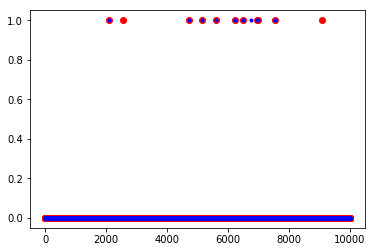

total number of anomalies predicted (red dots at 1) = 11
total number of actual anomalies (blue dots at 1) = 10
total number of anomalies truely predicted/true positive (blue red overlapped at 1)= 9
True  positive rate (TPR), Sensitivity, Prob of detection = 0.9
False negative rate (FNR), Miss rate= 0.1
True  negative rate (TNR), Specificity, Selectivity = 0.9998
False positive rate (FPR), Fall-out, Prob of false alarm = 0.0002
Normalized confusion matrix
[[1.e+00 2.e-04]
 [1.e-01 9.e-01]]


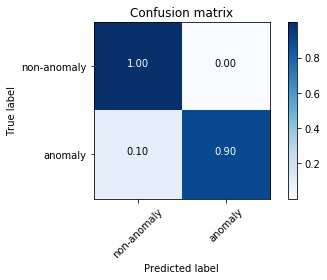

Prevalence = 0.1%, close to the population anomaly 0.17%
Accuracy = 0.9997
Positive Predictive Value (PPV), Precision = 0.8182
False discovery rate (FDR) = 0.1818
False omission rate (FOR) = 0.0001
Negative predictive value (NPV) = 0.9999
F1 score = 2*PPV*TPR/(PPV+TPR) = 0.8571428571428572
Fbeta score = (1+beta^2)*PPV*TPR/(beta^2*PPV+TPR) = 0.8333


In [69]:
#plt.plot(range(0,prediction_samp),test_data,'b.')
threshold = 0.7

ia      = np.nonzero(y_true==1)[0]
ina     = np.nonzero(y_true==0)[0]
preda   = np.asarray([i>threshold for i in y]) # boolean index for anom
predna  = np.asarray([i<=threshold for i in y]) # boolean index for non-anom
ipreda  = np.nonzero(preda)[0] # index of anom
ipredna = np.nonzero(predna)[0] # index of non-anom
npreda  = preda.sum() # number of predicted anom
npredna = predna.sum() # number of predicted non-anom
y_test  = np.array(y)
y_test[ipreda] = 1
y_test[ipredna] = 0
#y[i<=0.5 for i in y]=0
plt.plot(range(0,prediction_samp),y_test,'ro')
plt.plot(range(0,prediction_samp),y_true,'b.')
plt.show()
nactuala   = sum(i==1 for i in y_true)
nactualna = sum(i==0 for i in y_true)
tp = len(set(ipreda)&set(ia))
fn = len(set(ipredna)&set(ia))
tn = len(set(ipredna)&set(ina))
fp = len(set(ipreda)&set(ina))
tpr = tp/nactuala
fnr = fn/nactuala
tnr = tn/nactualna
fpr = fp/nactualna
ppv = tp/npreda
f1_score = 2*(1/(1/tpr+1/ppv)) #f1 = sklearn.metrics.f1_score(y_true,y_test)
beta = 0.5
fbeta_score = (1+beta**2)*tpr*ppv/(beta**2*ppv+tpr) #fb = sklearn.metrics.fbeta_score(y_true,y_test,beta)
print('total number of anomalies predicted (red dots at 1) = '+str(npreda))
print('total number of actual anomalies (blue dots at 1) = '+ str(*nactuala))
print('total number of anomalies truely predicted/true positive (blue red overlapped at 1)= '+str(tp))
#print('total number of non-anomalies predicted = '+str(np.count_nonzero(ineg)))
print('True  positive rate (TPR), Sensitivity, Prob of detection = '+str(*tpr)) # model forecast pos and actually pos
print('False negative rate (FNR), Miss rate= '+str(*fnr))
print('True  negative rate (TNR), Specificity, Selectivity = '+str(*tnr.round(4))) # model forecast neg but actually pos
print('False positive rate (FPR), Fall-out, Prob of false alarm = '+str(*fpr.round(4))) 
cnf_matrix = sklearn.metrics.confusion_matrix(y_true, y_test,labels=[0,1])
plt.figure()
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['non-anomaly','anomaly'], normalize=True,
                      title='Confusion matrix')
plt.show()

print('Prevalence = %s%%, close to the population anomaly 0.17%%'%str(*nactuala/prediction_samp*100))
print('Accuracy = '+str((tp+tn)/prediction_samp))
print('Positive Predictive Value (PPV), Precision = '+str(ppv.round(4)))
print('False discovery rate (FDR) = '+str((fp/npreda).round(4)))
print('False omission rate (FOR) = '+str((fn/npredna).round(4)))
print('Negative predictive value (NPV) = '+str((tn/npredna).round(4)))
print('F1 score = 2*PPV*TPR/(PPV+TPR) = '+str(*f1_score)) # the harmonic mean of precision and recall
print('Fbeta score = (1+beta^2)*PPV*TPR/(beta^2*PPV+TPR) = '+str(*fbeta_score.round(4))) # the harmonic mean of precision and recall
# tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true, y_test,labels=[0,1]).ravel()


As shown in the above figure, with a test sample size of 10000, the algorithm captured 9 out of 10 actual anomalies (blue dots at ones). This model is good with small FPR (0.1) and large TPR (0.9), but just ok when looking at F1 and Fbeta scores.

So can we do better by shifting the threshold?

# Sensitivity analysis

The threshold essentially controls our model performance, which in turns affects the sensitivity/TPR/recall. 

Let's look at the two figures below to understand how the threshold can affect our results. Suppose there are two predicted probability distributions: true negative (blue) and true positive (red) classes tagged on the predicted values (0 to 1 on x-axis). Given a threshold value (black stick), the areas under the distributions separated by the threhold are the (TPR,TNR,FPR,FNR) quadruple. For overlapped and shifted distributions (bottom figure), the threhold is definitely not 0.5 anymore.

How does this related to Receiver Operating Characteristic (ROC) curve?

The ROC curve is just the (FPR,TPR) tuples to the right of the threshold formed by shifting the entire threshold from 0 to 1. The Area Under Curve (AUC) shows how "separated/overlapped" the predicted distributions negative class (blue) and true predicted positive class (red) distributions are. The larger AUC shows a better separated predicted distributions, i.e., higher TPR with lower FPR easily obtained! 

Top (bottom) figure shows the two distributions separated (overlapped) and the ROC curve hugging (parting) the top-left corner, which is a good (bad) prediction model! 


<img src="roc3.png" alt="drawing" width="400"/>
<img src="roc4.png" alt="drawing" width="400"/>

Let's see how the two distributions look like in our case:

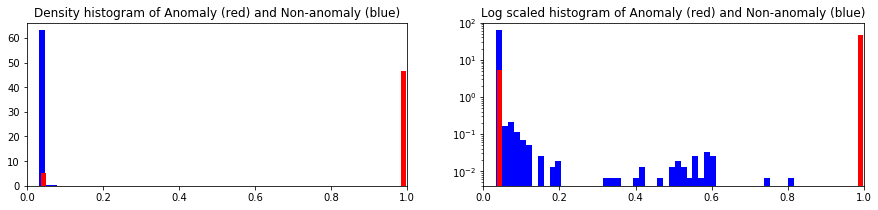

In [70]:
def plot_np_dist(y_true,y_pred):
    nbins = 50
    plt.figure(figsize=(15,3))
    plt.subplot(121)
    plt.title('Density histogram of Anomaly (red) and Non-anomaly (blue)')
    plt.hist(y_pred[np.nonzero(y_true==0)],density=True,bins=nbins,color='b',rwidth=1);     
    plt.hist(y_pred[np.nonzero(y_true)],density=True,bins=nbins,color='r',rwidth=.7);     
    plt.xlim([0,1])
    plt.subplot(122)
    #plt.figure(figsize=(8,3))
    plt.title('Log scaled histogram of Anomaly (red) and Non-anomaly (blue)')
    plt.hist(y_pred[np.nonzero(y_true==0)],density=True,log=True,bins=nbins,color='b',rwidth=1);     
    plt.hist(y_pred[np.nonzero(y_true)],density=True,log=True,bins=nbins,color='r',rwidth=.7);     
    plt.xlim([0,1])
    plt.show()
    
y_test = np.array(y)
y_true = test[:prediction_samp,-1].reshape(-1,1)
plot_np_dist(y_true,y_test)



At first glance using the desity (left panel), the two distributions are very well separated! But when the zero values are removed in the log histogram (right panel), results seems a little tricky. The threshold might be better at a higher value (e.g., 0.7) to get better seperation for such small sample size.

**Here's the catch!** When there're imbalanced classes, a few false positive cases will generate a tiny FPR (e.g., two out of a thousand cases), and seems like a good ROC curve. But these false positive cases will greatly contaminate the small anomaly samples! This happened when you look at the 14 cases predicted, but only 9 are actually true anomalies.

Let's see how ROC may be misleading at this small anomaly sample:

Area Under Curve = 98.80


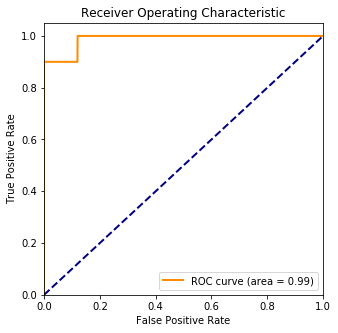

In [72]:
area_under_roc = sklearn.metrics.roc_auc_score(y_true, y_test) 
print('Area Under Curve = {:0.2f}'.format(area_under_roc*100))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_test)
roc_auc = sklearn.metrics.auc(fpr, tpr) # Area Under ROC Curve

#plt.figure()
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# ROC considers all thresholds of probabilities to plot the yellow curve
# suppose at FPR=0.1, the TPR=0.9
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

The AUC is 99%! But as we know if we want to reduce the small number of false positive cases, this curve won't tell the whole story. 

# Summary
Key takeaway:

* The imbalanced classes with multi-features can be trained by anomaly duplication with great prediction accuracy
* If one tries to reduce false positive cases, simple histogram and confusion matrix may be more revealing than ROC 
* Use F1 and Fbeta scores to represent prediction accuracy



# Reference
[F1 score](https://en.wikipedia.org/wiki/F1_score)